In [2]:
#dependencies


!pip install tf-nightly

 
import os
import pandas as pd
import tensorflow as tf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy as sp
from google.colab import drive

import pickle

%matplotlib inline
 
# library for train test split
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_fscore_support as score

# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.3'
spark_version = 'spark-3.2.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.2.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.2.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3.2"

# Start a SparkSession
import findspark
findspark.init()

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.2/589.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 KB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 85.5 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled 

(keras.layers.pooling.global_average_pooling1d.GlobalAveragePooling1D,
 keras.layers.core.dense.Dense,
 keras.layers.regularization.dropout.Dropout,
 keras.layers.rnn.lstm.LSTM,
 keras.layers.rnn.bidirectional.Bidirectional)

In [3]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("tokenizing").getOrCreate()

In [ ]:
#read csv file
#smsbase_df=pd.read_csv("Resources/sms_spam.csv", encoding = 'ISO-8859-1', usecols=[0,1])
#smsbase_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
from pyspark import SparkFiles
#url ="https://2u-data-curriculum-team.s3.amazonaws.com/dataviz-classroom/v1.1/22-big-data/day_1/nutrition.csv"
#smsbase_df=pd.read_csv("Resources/sms_spam.csv", encoding = 'ISO-8859-1', usecols=[0,1])
spark.sparkContext.addFile("Resources/sms_spam.csv")
smsbase_df = spark.read.csv(SparkFiles.get("sms_spam.csv"), sep=",", header=True, ignoreLeadingWhiteSpace=True) #Observe the need to use ignoreLeadingWhiteSpace=True, otherwise a leading whitespace will appear in the column names

# Show DataFrame
smsbase_df.show() 

+----+--------------------+----+----+----+
|  v1|                  v2| _c2| _c3| _c4|
+----+--------------------+----+----+----+
| ham|Go until jurong p...|null|null|null|
| ham|Ok lar... Joking ...|null|null|null|
|spam|Free entry in 2 a...|null|null|null|
| ham|U dun say so earl...|null|null|null|
| ham|Nah I don't think...|null|null|null|
|spam|FreeMsg Hey there...|null|null|null|
| ham|Even my brother i...|null|null|null|
| ham|As per your reque...|null|null|null|
|spam|WINNER!! As a val...|null|null|null|
|spam|Had your mobile 1...|null|null|null|
| ham|I'm gonna be home...|null|null|null|
|spam|SIX chances to wi...|null|null|null|
|spam|URGENT! You have ...|null|null|null|
| ham|I've been searchi...|null|null|null|
| ham|I HAVE A DATE ON ...|null|null|null|
|spam|XXXMobileMovieClu...|null|null|null|
| ham|Oh k...i'm watchi...|null|null|null|
| ham|Eh u remember how...|null|null|null|
| ham|Fine if that��s t...|null|null|null|
|spam|England v Macedon...|null|null|null|
+----+-----

In [5]:
from pyspark.ml.feature import RegexTokenizer, Tokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

In [6]:
#columns = ["v1", "v2"]
sms_df = smsbase_df.select(("v1"), ("v2"))

sms_df.show()

+----+--------------------+
|  v1|                  v2|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
|spam|FreeMsg Hey there...|
| ham|Even my brother i...|
| ham|As per your reque...|
|spam|WINNER!! As a val...|
|spam|Had your mobile 1...|
| ham|I'm gonna be home...|
|spam|SIX chances to wi...|
|spam|URGENT! You have ...|
| ham|I've been searchi...|
| ham|I HAVE A DATE ON ...|
|spam|XXXMobileMovieClu...|
| ham|Oh k...i'm watchi...|
| ham|Eh u remember how...|
| ham|Fine if that��s t...|
|spam|England v Macedon...|
+----+--------------------+
only showing top 20 rows



In [7]:
sms_df.dropDuplicates(subset=['v2'])
print(sms_df)

DataFrame[v1: string, v2: string]


In [8]:
sms_df.count()

5574

In [9]:
sms_df = sms_df.filter(sms_df.v2.isNotNull())

In [10]:
sms_df.count()

5573

In [11]:
sms_df = sms_df.sort("v1")

In [12]:
sms_df.count()

5573

In [13]:
from pyspark.sql import functions as f
smsq_df = sms_df.select("v2", f.translate(f.col("v2"), "�", "").alias("v3")).show()  


+--------------------+--------------------+
|                  v2|                  v3|
+--------------------+--------------------+
|I���m going to tr...|Im going to try f...|
| WHO ARE YOU SEEING?| WHO ARE YOU SEEING?|
|So �_ pay first l...|So _ pay first la...|
|Ok lar... Joking ...|Ok lar... Joking ...|
|Aft i finish my l...|Aft i finish my l...|
|U dun say so earl...|U dun say so earl...|
|Ffffffffff. Alrig...|Ffffffffff. Alrig...|
|Did you catch the...|Did you catch the...|
|I'm back &amp; we...|I'm back &amp; we...|
|As per your reque...|As per your reque...|
|Ahhh. Work. I vag...|Ahhh. Work. I vag...|
|I've been searchi...|I've been searchi...|
|Wait that's still...|Wait that's still...|
|Oh k...i'm watchi...|Oh k...i'm watchi...|
|Yeah he got in at...|Yeah he got in at...|
|Fine if that��s t...|Fine if thats the...|
|K tell me anythin...|K tell me anythin...|
|Go until jurong p...|Go until jurong p...|
|For fear of faint...|For fear of faint...|
|Even my brother i...|Even my br

In [14]:

tokened = Tokenizer(inputCol="v2", outputCol="words")
tokenized = tokened.transform(sms_df)
tokenized.show()
spark = SparkSession.builder.appName("tokenizing").getOrCreate()

+---+--------------------+--------------------+
| v1|                  v2|               words|
+---+--------------------+--------------------+
|ham|I���m going to tr...|[i���m, going, to...|
|ham| WHO ARE YOU SEEING?|[who, are, you, s...|
|ham|So �_ pay first l...|[so, �_, pay, fir...|
|ham|Ok lar... Joking ...|[ok, lar..., joki...|
|ham|Aft i finish my l...|[aft, i, finish, ...|
|ham|U dun say so earl...|[u, dun, say, so,...|
|ham|Ffffffffff. Alrig...|[ffffffffff., alr...|
|ham|Did you catch the...|[did, you, catch,...|
|ham|I'm back &amp; we...|[i'm, back, &amp;...|
|ham|As per your reque...|[as, per, your, r...|
|ham|Ahhh. Work. I vag...|[ahhh., work., i,...|
|ham|I've been searchi...|[i've, been, sear...|
|ham|Wait that's still...|[wait, that's, st...|
|ham|Oh k...i'm watchi...|[oh, k...i'm, wat...|
|ham|Yeah he got in at...|[yeah, he, got, i...|
|ham|Fine if that��s t...|[fine, if, that��...|
|ham|K tell me anythin...|[k, tell, me, any...|
|ham|Go until jurong p...|[go, until, ju

In [15]:
# Create a function to return the length of a list
def word_list_length(word_list):
    return len(word_list)

In [16]:
# Create a user defined function 
count_tokens = udf(word_list_length, IntegerType())
count_tokens


<function __main__.word_list_length(word_list)>

In [17]:
tokens_df = tokenized.select("v1", "words")\
    .withColumn("tokens", count_tokens(col("words"))) 

In [18]:
tokens_df.show()

+---+--------------------+------+
| v1|               words|tokens|
+---+--------------------+------+
|ham|[go, until, juron...|    20|
|ham|[ok, lar..., joki...|     6|
|ham|[u, dun, say, so,...|    11|
|ham|[nah, i, don't, t...|    13|
|ham|[even, my, brothe...|    16|
|ham|[as, per, your, r...|    26|
|ham|[i'm, gonna, be, ...|    21|
|ham|[i've, been, sear...|    37|
|ham|[i, have, a, date...|     8|
|ham|[oh, k...i'm, wat...|     4|
|ham|[eh, u, remember,...|    19|
|ham|[fine, if, that��...|    13|
|ham|[is, that, seriou...|     8|
|ham|[i���m, going, to...|    11|
|ham|[so, �_, pay, fir...|    11|
|ham|[aft, i, finish, ...|    20|
|ham|[ffffffffff., alr...|    11|
|ham|[just, forced, my...|    28|
|ham|[lol, your, alway...|     5|
|ham|[did, you, catch,...|    32|
+---+--------------------+------+
only showing top 20 rows



In [19]:
#now in Pandas
smsp_df = tokens_df.toPandas()

In [20]:
smsp_df.v1.value_counts()

ham       4825
spam       747
ham"""       1
Name: v1, dtype: int64

In [21]:
smsd_df = smsp_df[smsp_df["v1"]!= 'ham"""']
print(smsd_df)

        v1                                              words  tokens
0      ham  [go, until, jurong, point,, crazy.., available...      20
1      ham               [ok, lar..., joking, wif, u, oni...]       6
2      ham  [u, dun, say, so, early, hor..., u, c, already...      11
3      ham  [nah, i, don't, think, he, goes, to, usf,, he,...      13
4      ham  [even, my, brother, is, not, like, to, speak, ...      16
...    ...                                                ...     ...
5568  spam  [want, explicit, sex, in, 30, secs?, ring, 020...      16
5569  spam  [asked, 3mobile, if, 0870, chatlines, inclu, i...      33
5570  spam  [had, your, contract, mobile, 11, mnths?, late...      28
5571  spam  [reminder, from, o2:, to, get, 2.50, pounds, f...      28
5572  spam  [this, is, the, 2nd, time, we, have, tried, 2,...      30

[5572 rows x 3 columns]


In [22]:
smsd_df.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [23]:
data = smsd_df.rename(columns={"v1": "label", "words": "message", "tokens": "tokens"})
data.head()

,label,message,tokens
0,ham,"[go, until, jurong, point,, crazy.., available...",20
1,ham,"[ok, lar..., joking, wif, u, oni...]",6
2,ham,"[u, dun, say, so, early, hor..., u, c, already...",11
3,ham,"[nah, i, don't, think, he, goes, to, usf,, he,...",13
4,ham,"[even, my, brother, is, not, like, to, speak, ...",16


In [24]:
data.groupby('label').describe().T 

label                 ham        spam
tokens count  4825.000000  747.000000
       mean     14.290570   23.851406
       std      11.531418    5.811898
       min       1.000000    2.000000
       25%       7.000000   22.000000
       50%      11.000000   25.000000
       75%      19.000000   28.000000
       max     171.000000   35.000000

In [25]:
data.head()

,label,message,tokens
0,ham,"[go, until, jurong, point,, crazy.., available...",20
1,ham,"[ok, lar..., joking, wif, u, oni...]",6
2,ham,"[u, dun, say, so, early, hor..., u, c, already...",11
3,ham,"[nah, i, don't, think, he, goes, to, usf,, he,...",13
4,ham,"[even, my, brother, is, not, like, to, speak, ...",16


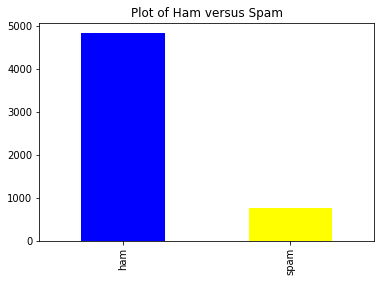

In [26]:
count_Class=pd.value_counts(data["label"], sort= True)
count_Class.plot(kind = 'bar',color = ["blue","yellow"])
plt.title('Plot of Ham versus Spam')
plt.show();

In [27]:
data.message = data.message.apply(lambda x: ' '.join([str(i) for i in x]))


In [28]:
#Now Naive Bayes Model
f = feature_extraction.text.CountVectorizer(stop_words = 'english')
X = f.fit_transform(data["message"])
np.shape(X)

(5572, 8357)

In [29]:
# Classifying spam and not spam msgs as 1 and 0

data["label"]=data["label"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['label'], test_size=0.70, random_state=42)

In [30]:
y_test

3245    0
944     0
1044    0
2484    0
812     0
       ..
1441    0
4174    0
5430    1
3811    0
1535    0
Name: label, Length: 3901, dtype: int64

In [31]:
y_train

2913    0
3188    0
1273    0
2467    0
3688    0
       ..
3772    0
5192    1
5227    1
5391    1
860     0
Name: label, Length: 1671, dtype: int64

In [32]:
from sklearn.metrics import precision_recall_fscore_support as score
 

In [33]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1

In [34]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,0.999402,0.961548,0.920696,0.813675
1,0.11001,0.998205,0.965137,0.955513,0.813839
2,0.22001,0.998205,0.966163,0.951644,0.821369
3,0.33001,0.998205,0.968470,0.949710,0.835034
4,0.44001,0.997008,0.970264,0.945841,0.847487
5,0.55001,0.997008,0.975391,0.943907,0.879279
6,0.66001,0.997008,0.975904,0.938104,0.886654
7,0.77001,0.995212,0.977698,0.936170,0.899628
8,0.88001,0.994614,0.978980,0.932302,0.911153
9,0.99001,0.994614,0.978723,0.926499,0.914122


In [51]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]

alpha             9.570010
Train Accuracy    0.979054
Test Accuracy     0.970008
Test Recall       0.773694
Test Precision    1.000000
Name: 87, dtype: float64

In [54]:
results = models.iloc[best_index, :]
best_alpha = results["alpha"]
best_alpha

9.57001

In [57]:
bayes = naive_bayes.MultinomialNB(alpha=best_alpha)
Bayes_Model = bayes.fit(X_train, y_train)
Bayes_Model

MultinomialNB(alpha=9.57001)

In [58]:
# Export our Naive Bayes Model to joblib file
import joblib
joblib.dump(Bayes_Model, "Resources/bayes_model.joblib")

['Resources/bayes_model.joblib']

In [59]:
#Now Random Forest Model
rf = RandomForestClassifier(n_estimators=100,max_depth=None,n_jobs=-1)
rf_model = rf.fit(X_train,y_train)
     

In [60]:
y_pred=rf_model.predict(X_test)
precision,recall,fscore,support =score(y_test,y_pred,pos_label=1, average ='binary')
print('Precision : {} / Recall : {} / fscore : {} / Accuracy: {}'.format(round(precision,3),round(recall,3),round(fscore,3),round((y_pred==y_test).sum()/len(y_test),3)))
     


Precision : 0.995 / Recall : 0.7 / fscore : 0.822 / Accuracy: 0.96


In [61]:
# Export our random forest model to joblib file

joblib.dump(rf_model, "Resources/random_forest.joblib")

['Resources/random_forest.joblib']